# Проект модуля. Нейросеть для предсказания калорийности блюд

В этом проекте вы реализуете нейросеть, которая будет определять калорийность блюд. В вашем распоряжении будет датасет с фотографиями тарелок с разными блюдами, а также текстовое описание их ингредиентного состава.
В этом уроке вы узнаете, какую задачу вам предстоит выполнить и как работать над проектом, а также несколько организационных деталей. 

Цель

Получить DL-модель, способную оценить калорийность блюда

Целевая метрика

Модель будет считаться готовой к интеграции в продукт при точности оценки MAE < 50 (MAE — Mean Absolute Error) на тестовой выборке. 

Датасет

Вы поработаете с датасетом (1.3 ГБ), который содержит фотографии блюд, описание ингредиентов, а также общую массу порции и калорийность.

data/ingredients.csv

id — ID ингредиента.

ingr — название ингредиента.

data/dish.csv

dish_id — ID блюда.

total_calories — общее число калорий. Это целевая переменная.

total_mass — масса блюда.

ingredients — список всех ID ингредиентов в формате ingr_0000000122;ingr_0000000026;.., где ненулевая часть соответствует ID ингредиента из data/ingredients.csv.

split — метка, указывающая, куда отнести блюдо: train/test. Эта метка поможет разделить датасет при тренировке.

data/images — датасет с фотографиями блюд, каждая директория соответствует dish_id из data/dish.csv и содержит rgb.png фото блюда.

## Этап 0. Подготовка и загрузка данных

In [ ]:
# pip install pandas matplotlib seaborn torch transformers timm albumentations scikit-learn

In [ ]:
# Ячейка 1: Импорты и установки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import os
import ast
import warnings
warnings.filterwarnings('ignore')

# PyTorch импорты
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

# Transformers и модели
from transformers import AutoTokenizer, AutoModel
import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

# Установка seed для воспроизводимости
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)

set_seed(42)

print("✅ Все импорты завершены")

In [ ]:
# Загрузка данных
df_dish = pd.read_csv('nutrition/data/dish.csv')
df_ingredients = pd.read_csv('nutrition/data/ingredients.csv')

## Этап 1. Проведите исследовательский анализ (EDA)

Загрузите датасет и визуализируйте часть данных. Изучите то, с чем предстоит работать
Сформируйте видение:
как вы будете решать задачу,
какие подходы к обогащению/аугментации данных примените и почему,
на какие метрики будете ориентироваться при обучении.
Результаты: EDA и выводы о подходах к решению задачи. 

In [ ]:
# 1. Общая информация о датасете блюд
print("=== ИНФОРМАЦИЯ О ДАТАСЕТЕ БЛЮД ===")
print(df_dish.info())

=== ИНФОРМАЦИЯ О ДАТАСЕТЕ БЛЮД ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3262 entries, 0 to 3261
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   dish_id         3262 non-null   object 
 1   total_calories  3262 non-null   float64
 2   total_mass      3262 non-null   float64
 3   ingredients     3262 non-null   object 
 4   split           3262 non-null   object 
dtypes: float64(2), object(3)
memory usage: 127.6+ KB
None


### total_calories and total mass

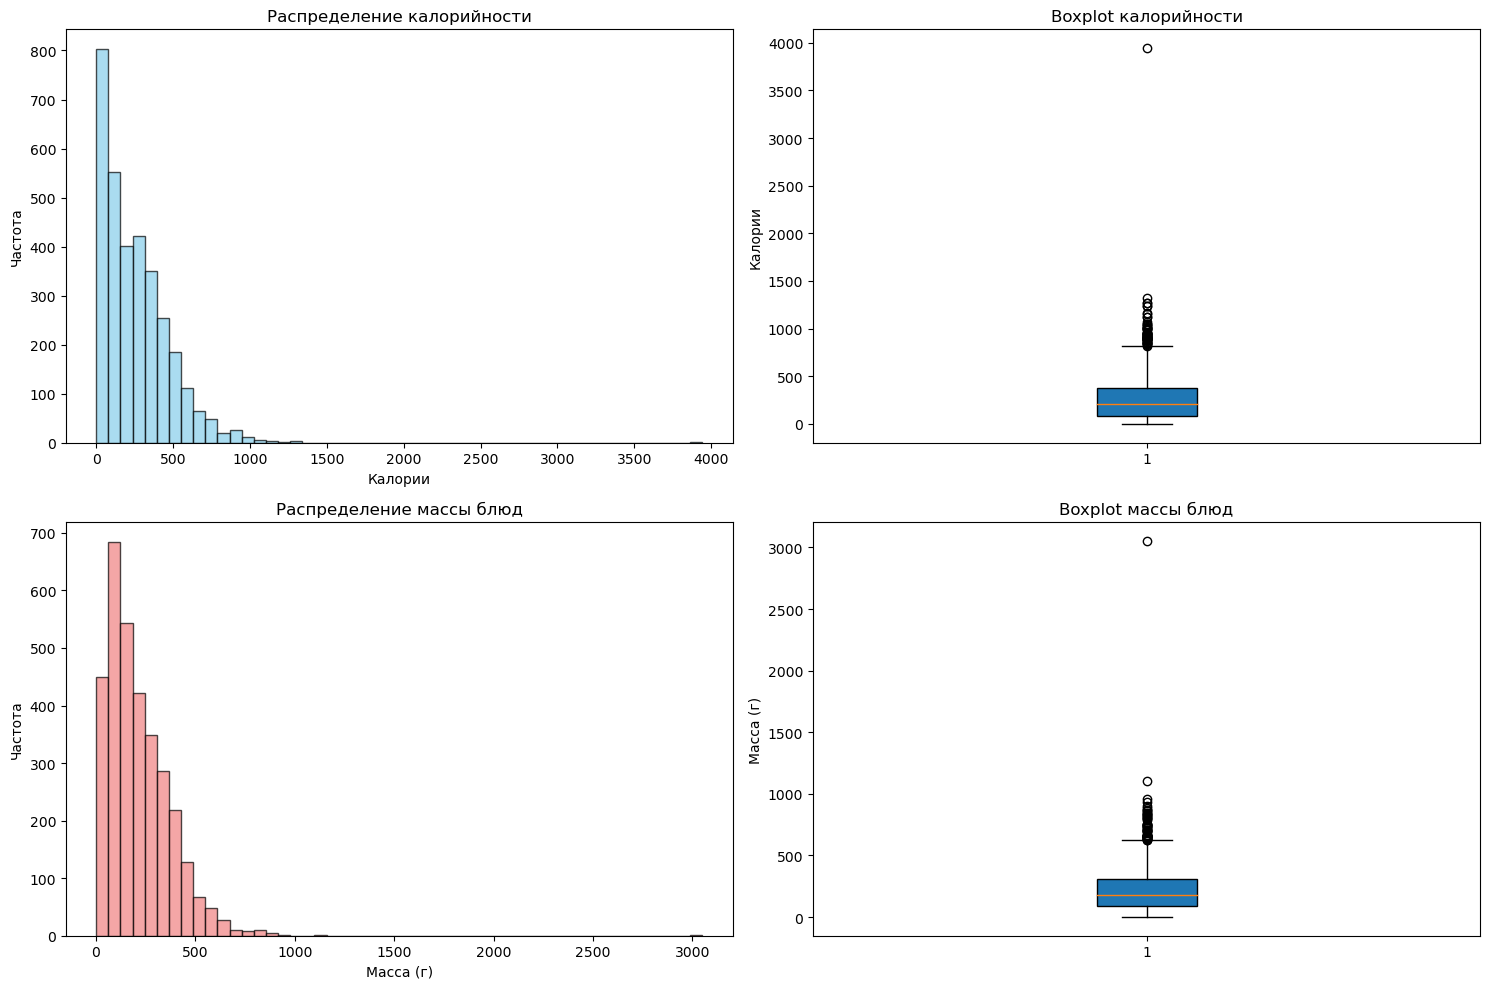

In [23]:
# 2. Анализ целевой переменной
plt.figure(figsize=(15, 10))

# Калории
plt.subplot(2, 2, 1)
plt.hist(df_dish['total_calories'], bins=50, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Распределение калорийности')
plt.xlabel('Калории')
plt.ylabel('Частота')

plt.subplot(2, 2, 2)
plt.boxplot(df_dish['total_calories'], vert=True, patch_artist=True)
plt.title('Boxplot калорийности')
plt.ylabel('Калории')

# Масса
plt.subplot(2, 2, 3)
plt.hist(df_dish['total_mass'], bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
plt.title('Распределение массы блюд')
plt.xlabel('Масса (г)')
plt.ylabel('Частота')

plt.subplot(2, 2, 4)
plt.boxplot(df_dish['total_mass'], vert=True, patch_artist=True)
plt.title('Boxplot массы блюд')
plt.ylabel('Масса (г)')

plt.tight_layout()
plt.show()

#### Вывод:

Присутсвует выброс 

In [24]:
# Находим максимальное значение по калориям
max_calories_row = df_dish.loc[df_dish['total_calories'].idxmax()]
print("=== БЛЮДО С МАКСИМАЛЬНОЙ КАЛОРИЙНОСТЬЮ ===")
print(f"ID блюда: {max_calories_row['dish_id']}")
print(f"Калории: {max_calories_row['total_calories']:.2f}")
print(f"Масса: {max_calories_row['total_mass']:.2f} г")

print("\n" + "="*50)

# Находим максимальное значение по массе
max_mass_row = df_dish.loc[df_dish['total_mass'].idxmax()]
print("=== БЛЮДО С МАКСИМАЛЬНОЙ МАССОЙ ===")
print(f"ID блюда: {max_mass_row['dish_id']}")
print(f"Калории: {max_mass_row['total_calories']:.2f}")
print(f"Масса: {max_mass_row['total_mass']:.2f} г")

=== БЛЮДО С МАКСИМАЛЬНОЙ КАЛОРИЙНОСТЬЮ ===
ID блюда: dish_1560974769
Калории: 3943.33
Масса: 3051.00 г

=== БЛЮДО С МАКСИМАЛЬНОЙ МАССОЙ ===
ID блюда: dish_1560974769
Калории: 3943.33
Масса: 3051.00 г


#### Вывод:

ID блюда выброса как по массе, так и по калориям совпадает: dish_1560974769 

dish_1560974769 необходимо удалить

In [ ]:
# Находим блюдо с максимальной калорийностью
max_calorie_dish = df_dish[df_dish['total_calories'] == df_dish['total_calories'].max()]
print("=== БЛЮДО С МАКСИМАЛЬНОЙ КАЛОРИЙНОСТЬЮ ===")
print(f"ID блюда: {max_calorie_dish['dish_id'].values[0]}")
print(f"Калорийность: {max_calorie_dish['total_calories'].values[0]}")

# Удаляем из df_dish
initial_shape = df_dish.shape
df_dish = df_dish[df_dish['dish_id'] != 'dish_1560974769']
print(f"\nУдалено из df_dish: {initial_shape[0] - df_dish.shape[0]} записей")

# Удаляем изображение
def delete_dish_image(dish_id):
    """Удаляет папку с изображением блюда"""
    image_dir = f"nutrition/data/images/{dish_id}"
    if os.path.exists(image_dir):
        # Удаляем все файлы в папке
        for file in os.listdir(image_dir):
            file_path = os.path.join(image_dir, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
        # Удаляем саму папку
        os.rmdir(image_dir)
        print(f"Изображение для {dish_id} удалено")
        return True
    else:
        print(f"Изображение для {dish_id} не найдено")
        return False

# Удаляем изображение
image_deleted = delete_dish_image('dish_1560974769')

# Проверяем результаты
print(f"\n=== РЕЗУЛЬТАТЫ ===")
print(f"Осталось блюд в df_dish: {df_dish.shape[0]}")
print(f"Осталось записей в df_ingredients: {df_ingredients.shape[0]}")
print(f"Изображение удалено: {image_deleted}")

# Проверяем, что блюдо действительно удалено
dish_exists = 'dish_1560974769' in df_dish['dish_id'].values
print(f"Блюдо dish_1560974769 еще в датасете: {dish_exists}")

### ingredients     


=== СТАТИСТИКИ ПО ИНГРЕДИЕНТАМ ===
Среднее количество ингредиентов: 7.31
Максимальное количество ингредиентов: 34
Минимальное количество ингредиентов: 1
Медианное количество ингредиентов: 4.0


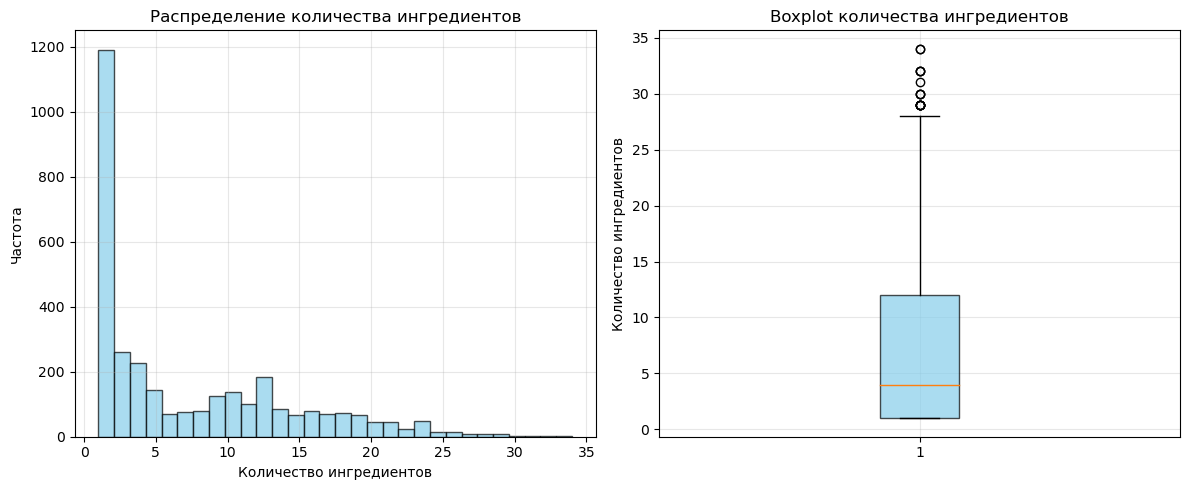

In [ ]:
# 3. Анализ ингредиентов
print("\n=== СТАТИСТИКИ ПО ИНГРЕДИЕНТАМ ===")
# Преобразуем строку с ингредиентами в список
df_dish['ingredients_list'] = df_dish['ingredients'].str.split(';')

# Количество ингредиентов в блюдах
df_dish['num_ingredients'] = df_dish['ingredients_list'].apply(len)
print(f"Среднее количество ингредиентов: {df_dish['num_ingredients'].mean():.2f}")
print(f"Максимальное количество ингредиентов: {df_dish['num_ingredients'].max()}")
print(f"Минимальное количество ингредиентов: {df_dish['num_ingredients'].min()}")
print(f"Медианное количество ингредиентов: {df_dish['num_ingredients'].median()}")

# Визуализация распределения количества ингредиентов
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
plt.hist(df_dish['num_ingredients'], bins=30, edgecolor='black', alpha=0.7, color='skyblue')
plt.title('Распределение количества ингредиентов')
plt.xlabel('Количество ингредиентов')
plt.ylabel('Частота')
plt.grid(True, alpha=0.3)

# Boxplot
plt.subplot(1, 2, 2)
plt.boxplot(df_dish['num_ingredients'], vert=True, patch_artist=True,
           boxprops=dict(facecolor='skyblue', alpha=0.7))
plt.title('Boxplot количества ингредиентов')
plt.ylabel('Количество ингредиентов')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### Вывод:

Большинство блюд имеют количество ингредиентов от 1 до 5


### Анализ изображений


=== АНАЛИЗ ИЗОБРАЖЕНИЙ ===
Доля блюд с изображениями от общего количества: 1.000


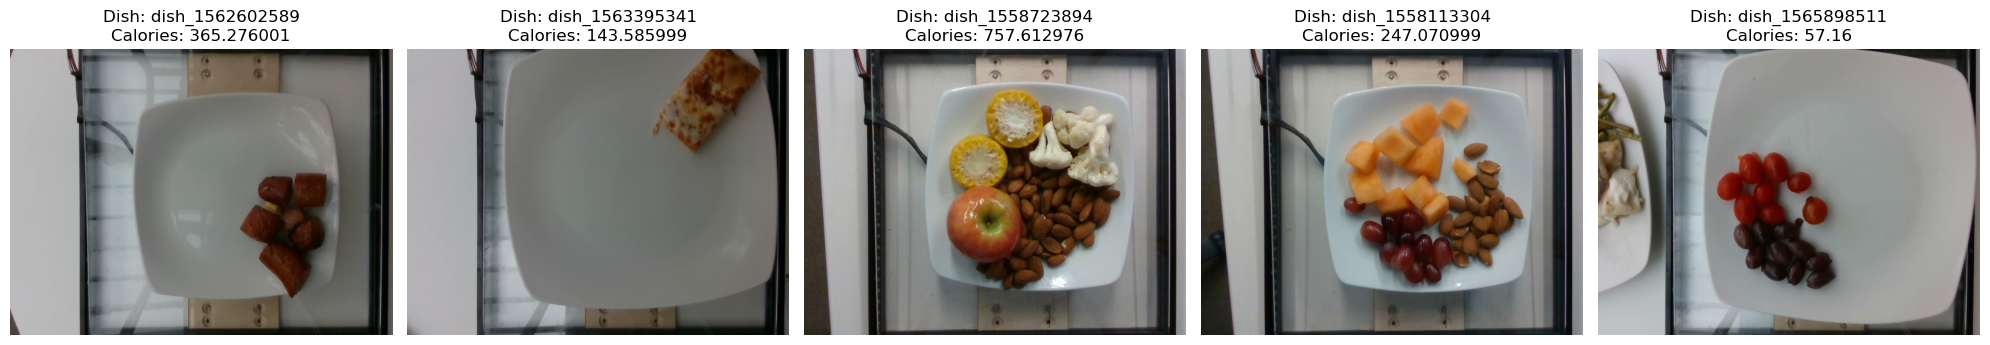

In [ ]:
# 4. Анализ изображений
print("\n=== АНАЛИЗ ИЗОБРАЖЕНИЙ ===")
train_images = df_dish[df_dish['split'] == 'train']['dish_id']
test_images = df_dish[df_dish['split'] == 'test']['dish_id']

def check_image_exists(dish_id):
    """Проверяет существование изображения для блюда"""
    image_path = f"nutrition/data/images/{dish_id}/rgb.png"
    return os.path.exists(image_path)

# Проверяем наличие изображений для подвыборки
df_dish['image_exists'] = df_dish['dish_id'].apply(check_image_exists)
print(f"Доля блюд с изображениями от общего количества: {df_dish['image_exists'].mean():.3f}")

# Просмотр примеров изображений
def show_sample_images(n_samples=5):
    """Показывает примеры изображений блюд"""
    sample_dishes = df_dish[df_dish['image_exists']].sample(n_samples)

    fig, axes = plt.subplots(1, n_samples, figsize=(20, 4))
    if n_samples == 1:
        axes = [axes]

    for i, (_, row) in enumerate(sample_dishes.iterrows()):
        img_path = f"nutrition/data/images/{row['dish_id']}/rgb.png"
        img = Image.open(img_path)

        axes[i].imshow(img)
        axes[i].set_title(f"Dish: {row['dish_id']}\nCalories: {row['total_calories']}")
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

show_sample_images(5)

#### Вывод:

Все блюда имеют изображение

### Итоги:

Целевая переменная: Калорийность имеет широкий диапазон значений. Есть выбросы.

Мультимодальность:

Текст: Список ингредиентов + масса блюда

Изображение: Фото блюда

Проблемы данных:

Выбросы в калорийности и массе

Подход к решению:

Использовать мультимодальность (текст + изображение)

Регрессионная задача (предсказание калорий)

Метрика: MAE < 50

## Этап 2. Реализуйте пайплайн обучения

Используя .py-файлы для сохранения кода, реализуйте:
Загрузчики данных и датасеты.
Опциональный код предобработки/аугментации данных.
Код обучения и валидации для импортирования в виде одной функции (train).
Конфиг-файл для запуска модели и сохранения результатов обучения.
Код для получения воспроизводимых результатов (seed) с выводом метрик.
Рекомендуемая структура: первый файл для работы с данными назовите dataset.py, второй — по запуску обучения — utils.py.
Результат: Python-файл или файлы с воспроизводимым кодом обучения. Все результаты должны воспроизводиться путём вызова train с передачей конфигурационного файла.

In [ ]:
# Ячейка 2: Конфигурация
class ImprovedConfig:
    SEED = 42
    DISH_CSV = "nutrition/data/dish.csv"
    INGREDIENTS_CSV = "nutrition/data/ingredients.csv"
    IMAGES_BASE_PATH = "nutrition/data/images"

    BATCH_SIZE = 32
    EPOCHS = 50
    DROPOUT = 0.25

    TEXT_LR = 1e-4
    IMAGE_LR = 1e-4
    HEAD_LR = 1e-3
    WEIGHT_DECAY = 1e-4

    # Модели
    TEXT_MODEL_NAME = "bert-base-uncased"
    IMAGE_MODEL_NAME = "resnet50"

    # Стратегия разморозки
    TEXT_MODEL_UNFREEZE = "encoder.layer.11|pooler"
    IMAGE_MODEL_UNFREEZE = "layer3|layer4"

    # Архитектура
    TEXT_DIM = 512
    IMAGE_DIM = 256
    MASS_DIM = 32
    HIDDEN_DIM = 256

    # Целевой loss для ранней остановки
    TARGET_LOSS = 50

    # Изображения
    IMAGE_SIZE = 224
    IMAGE_MEAN = [0.485, 0.456, 0.406]
    IMAGE_STD = [0.229, 0.224, 0.225]

    # Устройство
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Пути
    SAVE_PATH = "best_improved_model.pth"

cfg = ImprovedConfig()
print(f"✅ Конфигурация создана. Устройство: {cfg.DEVICE}")

In [ ]:
# Ячейка 3: Предобработка данных
def preprocess_data(df):
    """Улучшенная предобработка данных"""
    print("🔧 Начинаем предобработку данных...")

    # Удаляем известный выброс
    df = df[df['dish_id'] != 'dish_1560974769']

    return df

# Загружаем и предобрабатываем данные
df_dish = pd.read_csv(cfg.DISH_CSV)
df_ingredients = pd.read_csv(cfg.INGREDIENTS_CSV)

# Применяем предобработку
df_dish_processed = preprocess_data(df_dish)

In [ ]:
# Ячейка 4: Аугментации и трансформации
def get_enhanced_transforms(is_train=True):
    if is_train:
        return A.Compose([
            A.Resize(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
            A.HorizontalFlip(p=0.5),
            A.RandomBrightnessContrast(p=0.3),
            A.HueSaturationValue(p=0.3),
            A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=10, p=0.5),
            A.OneOf([
                A.GaussNoise(var_limit=(10.0, 50.0)),
                A.GaussianBlur(),
                A.MotionBlur(),
            ], p=0.3),
            A.Normalize(mean=cfg.IMAGE_MEAN, std=cfg.IMAGE_STD),
            ToTensorV2()
        ])
    else:
        return A.Compose([
            A.Resize(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
            A.Normalize(mean=cfg.IMAGE_MEAN, std=cfg.IMAGE_STD),
            ToTensorV2()
        ])

print("✅ Трансформации созданы")

In [ ]:
# Ячейка 5: Датасет
class EnhancedFoodDataset(Dataset):
    def __init__(self, df, ingredients_df, transform=None, is_train=True):
        self.df = df.reset_index(drop=True)
        self.ingredients_df = ingredients_df
        self.transform = transform
        self.is_train = is_train

        # Токенизатор
        self.tokenizer = AutoTokenizer.from_pretrained(cfg.TEXT_MODEL_NAME)

        # Словарь ингредиентов
        self.ingredients_dict = dict(zip(ingredients_df['id'], ingredients_df['ingr']))

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        dish_id = row['dish_id']

        # Целевая переменная
        calories = row['total_calories']
        mass = row['total_mass']

        # Текстовая обработка
        ingredients_list = row['ingredients'].split(';')
        ingredients_text = [self.ingredients_dict.get(ingr_id, "unknown") for ingr_id in ingredients_list]
        text_description = f"Dish with: {', '.join(ingredients_text)}. Total mass: {mass:.1f} grams."

        text_input = self.tokenizer(
            text_description,
            return_tensors='pt',
            padding='max_length',
            truncation=True,
            max_length=128
        )

        # Обработка изображения
        image_path = f"{cfg.IMAGES_BASE_PATH}/{dish_id}/rgb.png"
        try:
            image = Image.open(image_path).convert('RGB')
            image = np.array(image)

            if self.transform:
                image = self.transform(image=image)['image']
            else:
                transform = A.Compose([
                    A.Resize(cfg.IMAGE_SIZE, cfg.IMAGE_SIZE),
                    A.Normalize(mean=cfg.IMAGE_MEAN, std=cfg.IMAGE_STD),
                    ToTensorV2()
                ])
                image = transform(image=image)['image']

        except Exception as e:
            image = torch.zeros(3, cfg.IMAGE_SIZE, cfg.IMAGE_SIZE)
            print(f"⚠️ Ошибка загрузки изображения {dish_id}: {e}")

        return {
            'input_ids': text_input['input_ids'].squeeze(0),
            'attention_mask': text_input['attention_mask'].squeeze(0),
            'image': image,
            'calories': torch.tensor(calories, dtype=torch.float32),
            'mass': torch.tensor(mass, dtype=torch.float32),
            'dish_id': dish_id
        }

print("✅ Датасет создан")

In [ ]:
# Ячейка 6: Улучшенная модель
class ImprovedMultimodalModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        # Текстовая модель
        self.text_model = AutoModel.from_pretrained(config.TEXT_MODEL_NAME)
        self._unfreeze_text_layers()

        # Визуальная модель
        self.image_model = timm.create_model(config.IMAGE_MODEL_NAME,
                                           pretrained=True, num_classes=0)
        self._unfreeze_image_layers()

        # Проекционные слои
        text_dim = self.text_model.config.hidden_size
        image_dim = self.image_model.num_features

        self.text_proj = nn.Linear(text_dim, config.TEXT_DIM)
        self.image_proj = nn.Linear(image_dim, config.IMAGE_DIM)
        self.mass_proj = nn.Linear(1, config.MASS_DIM)

        # Fusion с учетом массы
        fusion_input_dim = config.TEXT_DIM + config.IMAGE_DIM + config.MASS_DIM
        self.fusion = nn.Sequential(
            nn.Linear(fusion_input_dim, config.HIDDEN_DIM),
            nn.BatchNorm1d(config.HIDDEN_DIM),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(config.HIDDEN_DIM, config.HIDDEN_DIM // 2),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
        )

        # Регрессор
        self.regressor = nn.Sequential(
            nn.Linear(config.HIDDEN_DIM // 2, 128),
            nn.ReLU(),
            nn.Dropout(config.DROPOUT),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def _unfreeze_text_layers(self):
        """Разморозка текстовой модели для BERT"""
        # Замораживаем все сначала
        for param in self.text_model.parameters():
            param.requires_grad = False

        # Размораживаем указанные слои
        for name, param in self.text_model.named_parameters():
            if any(unfreeze in name for unfreeze in self.config.TEXT_MODEL_UNFREEZE.split('|')):
                param.requires_grad = True
                print(f"🔓 Разморожен текстовый слой: {name}")

    def _unfreeze_image_layers(self):
        """Разморозка визуальной модели для ResNet50"""
        # Замораживаем все сначала
        for param in self.image_model.parameters():
            param.requires_grad = False

        # Размораживаем указанные слои
        for name, param in self.image_model.named_parameters():
            if any(unfreeze in name for unfreeze in self.config.IMAGE_MODEL_UNFREEZE.split('|')):
                param.requires_grad = True
                print(f"🔓 Разморожен визуальный слой: {name}")

    def forward(self, input_ids, attention_mask, image, mass):
        # Текст
        text_output = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_output.last_hidden_state[:, 0, :]  # [CLS] token
        text_emb = self.text_proj(text_features)

        # Изображение
        image_features = self.image_model(image)
        image_emb = self.image_proj(image_features)

        # Масса
        mass = mass.unsqueeze(1)
        mass_emb = self.mass_proj(mass)

        # Fusion
        combined = torch.cat([text_emb, image_emb, mass_emb], dim=1)
        fused = self.fusion(combined)

        # Предсказание
        return self.regressor(fused).squeeze(-1)

print("✅ Модель создана")

In [ ]:
# Ячейка 7: Функции для обучения
def train_epoch(model, dataloader, optimizer, criterion, device):
    """Одна эпоха обучения"""
    model.train()
    total_loss = 0

    for batch in tqdm(dataloader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        image = batch['image'].to(device)
        mass = batch['mass'].to(device)
        calories = batch['calories'].to(device)

        optimizer.zero_grad()
        predictions = model(input_ids, attention_mask, image, mass)
        loss = criterion(predictions, calories)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        total_loss += loss.item()

    return total_loss / len(dataloader)

def validate_epoch(model, dataloader, criterion, device):
    """Валидация"""
    model.eval()
    total_loss = 0
    all_predictions = []
    all_true = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Validation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            image = batch['image'].to(device)
            mass = batch['mass'].to(device)
            calories = batch['calories'].to(device)

            predictions = model(input_ids, attention_mask, image, mass)
            loss = criterion(predictions, calories)
            total_loss += loss.item()

            all_predictions.extend(predictions.cpu().numpy())
            all_true.extend(calories.cpu().numpy())

    mae = np.mean(np.abs(np.array(all_predictions) - np.array(all_true)))

    return total_loss / len(dataloader), mae, all_predictions, all_true

print("✅ Функции обучения созданы")

In [ ]:
# Ячейка 8: Подготовка данных
print("📦 Подготовка данных...")

# Разделяем данные
train_df = df_dish_processed[df_dish_processed['split'] == 'train'].copy()
test_df = df_dish_processed[df_dish_processed['split'] == 'test'].copy()

# Делим train на train/val
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=cfg.SEED)

print(f"📊 Размеры данных:")
print(f"   Train: {len(train_df)}")
print(f"   Val: {len(val_df)}")
print(f"   Test: {len(test_df)}")

# Создаем датасеты
train_dataset = EnhancedFoodDataset(train_df, df_ingredients, get_enhanced_transforms(True), True)
val_dataset = EnhancedFoodDataset(val_df, df_ingredients, get_enhanced_transforms(False), False)
test_dataset = EnhancedFoodDataset(test_df, df_ingredients, get_enhanced_transforms(False), False)

# Создаем даталоадеры
train_loader = DataLoader(train_dataset, batch_size=cfg.BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=cfg.BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ Данные подготовлены")

In [ ]:
# Ячейка 9: Инициализация модели и оптимизатора
print("🚀 Инициализация модели...")

model = ImprovedMultimodalModel(cfg).to(cfg.DEVICE)
optimizer = create_optimizer(model, cfg)
criterion = nn.L1Loss()

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=cfg.EPOCHS)

# Подсчет параметров
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"📊 Параметры модели:")
print(f"   Всего: {total_params:,}")
print(f"   Обучаемые: {trainable_params:,}")
print(f"   % обучаемых: {trainable_params/total_params*100:.2f}%")

print("✅ Модель инициализирована")

## Этап 3. Обучение модели

Выполните обучение модели на предоставленной ВМ с использованием кода с этапа 2. 
Запуск обучения проводите в Jupyter Notebook с логированием результатов в stdout ячейки. Чтобы ускорить обучение, используйте GPU, предоставленную в ВМ. 
По достижении заданного качества сохраните артефакт обученной модели. Модель должна сохраняться/импортироваться согласно пути, указанному в конфигурационном файле. 
Результат: артефакт обученной модели. 

In [ ]:
# Ячейка 10: ОБУЧЕНИЕ МОДЕЛИ
print("🎯 НАЧИНАЕМ ОБУЧЕНИЕ!")
print("=" * 50)

best_mae = float('inf')
best_test_mae = float('inf')
train_losses = []
val_maes = []
test_maes = []
patience_counter = 0
target_reached = False
phase = 1

for epoch in range(cfg.EPOCHS):
    print(f"\n📍 Эпоха {epoch+1}/{cfg.EPOCHS} (Фаза {phase})")

    # Обучение
    train_loss = train_epoch(model, train_loader, optimizer, criterion, cfg.DEVICE)
    train_losses.append(train_loss)

    # Валидация
    val_loss, val_mae, _, _ = validate_epoch(model, val_loader, criterion, cfg.DEVICE)
    val_maes.append(val_mae)

    # Тестирование (если Val MAE < 55 или каждые 5 эпох)
    if val_mae < 55 or epoch % 5 == 0:
        test_loss, test_mae, _, _ = validate_epoch(model, test_loader, criterion, cfg.DEVICE)
        test_maes.append(test_mae)
        print(f"   Test MAE: {test_mae:.2f}")

        # Сохраняем лучшую тестовую модель
        if test_mae < best_test_mae:
            best_test_mae = test_mae
            torch.save(model.state_dict(), "best_test_model.pth")
            print(f"   💾 Лучшая тестовая модель! Test MAE: {best_test_mae:.2f}")

        # ПРОВЕРКА: если Test MAE < 50, завершаем обучение
        if test_mae < 50:
            print(f"   🏆 ЦЕЛЬ НА ТЕСТЕ ДОСТИГНУТА! Test MAE: {test_mae:.2f} < 50. Завершение обучения.")
            target_reached = True
            break

    # Scheduler step
    scheduler.step()

    print(f"   Train Loss: {train_loss:.4f}")
    print(f"   Val MAE: {val_mae:.2f}")

    # Сохранение лучшей валидационной модели
    if val_mae < best_mae:
        best_mae = val_mae
        torch.save(model.state_dict(), cfg.SAVE_PATH)
        patience_counter = 0
        print(f"   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: {best_mae:.2f}")

        # Дополнительная проверка теста при улучшении валидации (если еще не проверяли в этом эпохе)
        if val_mae < 55 and epoch % 5 != 0:  # Если не проверяли тест выше
            test_loss, test_mae, _, _ = validate_epoch(model, test_loader, criterion, cfg.DEVICE)
            test_maes.append(test_mae)
            print(f"   📊 Test MAE (доп. проверка): {test_mae:.2f}")

            # Обновляем лучшую тестовую модель
            if test_mae < best_test_mae:
                best_test_mae = test_mae
                torch.save(model.state_dict(), "best_test_model.pth")
                print(f"   💾 Обновлена лучшая тестовая модель! Test MAE: {best_test_mae:.2f}")

            # ПРОВЕРКА: если Test MAE < 50, завершаем обучение
            if test_mae < 50:
                print(f"   🏆 ЦЕЛЬ НА ТЕСТЕ ДОСТИГНУТА! Test MAE: {test_mae:.2f} < 50. Завершение обучения.")
                target_reached = True
                break

    # Early stopping если нет улучшения
    else:
        patience_counter += 1
        if patience_counter >= 20:
            if phase == 2 and test_mae < best_test_mae + 5:
                print(f"   ⚠️ Patience исчерпан, но тест MAE приемлемый. Продолжаем...")
                patience_counter = 7
            else:
                print(f"   🛑 Early stopping на эпохе {epoch+1}")
                break

print(f"\n✅ Обучение завершено!")
print(f"   Лучший Val MAE: {best_mae:.2f}")
print(f"   Лучший Test MAE: {best_test_mae:.2f}")
print(f"   Цель MAE < 50 на тесте: {'✅ ДОСТИГНУТА' if best_test_mae < 50 else '❌ НЕ ДОСТИГНУТА'}")

# Загружаем лучшую тестовую модель для финального использования
if best_test_mae < float('inf'):
    model.load_state_dict(torch.load("best_test_model.pth", map_location=cfg.DEVICE, weights_only=True))
    print(f"   🎯 Загружена лучшая тестовая модель с MAE: {best_test_mae:.2f}")

🎯 НАЧИНАЕМ ОБУЧЕНИЕ!
==================================================

📍 Эпоха 1/100 (Фаза 1)
                                                           
   Test MAE: 161.08
   💾 Лучшая тестовая модель! Test MAE: 161.08
   Train Loss: 187.2567
   Val MAE: 157.83
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 157.83

📍 Эпоха 2/100 (Фаза 1)
                                                           
   Train Loss: 105.8328
   Val MAE: 88.76
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 88.76

📍 Эпоха 3/100 (Фаза 1)
                                                           
   Train Loss: 94.1461
   Val MAE: 73.56
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 73.56

📍 Эпоха 4/100 (Фаза 1)
                                                           
   Train Loss: 94.0445
   Val MAE: 68.53
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 68.53

📍 Эпоха 5/100 (Фаза 1)
                                                           
   Train Loss: 86.9530
   Val MAE: 65.74
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 65.74

📍 Эпоха 6/100 (Фаза 1)
                                                           
   Test MAE: 72.29
   💾 Лучшая тестовая модель! Test MAE: 72.29
   Train Loss: 79.3718
   Val MAE: 63.88
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 63.88

📍 Эпоха 7/100 (Фаза 1)
                                                           
   Train Loss: 78.0760
   Val MAE: 61.77
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 61.77

📍 Эпоха 8/100 (Фаза 1)
                                                           
   Train Loss: 80.7984
   Val MAE: 67.04

📍 Эпоха 9/100 (Фаза 1)
                                                           
   Train Loss: 74.0762
   Val MAE: 62.66

📍 Эпоха 10/100 (Фаза 1)
                                                           
   Train Loss: 71.6382
   Val MAE: 63.09

📍 Эпоха 11/100 (Фаза 1)
                                                           
   Test MAE: 63.71
   💾 Лучшая тестовая модель! Test MAE: 63.71
   Train Loss: 75.0916
   Val MAE: 62.93

📍 Эпоха 12/100 (Фаза 1)
                                                           
   Train Loss: 70.4806
   Val MAE: 61.00
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 61.00

📍 Эпоха 13/100 (Фаза 1)
                                                           
   Train Loss: 69.0105
   Val MAE: 56.30
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 56.30

📍 Эпоха 14/100 (Фаза 1)
                                                           
   Train Loss: 66.0513
   Val MAE: 56.03
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 56.03

📍 Эпоха 15/100 (Фаза 1)
                                                           
   Train Loss: 70.8377
   Val MAE: 57.91

📍 Эпоха 16/100 (Фаза 1)
                                                           
   Test MAE: 64.00
   Train Loss: 65.0730
   Val MAE: 55.03
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 55.03

📍 Эпоха 17/100 (Фаза 1)
                                                           
   Train Loss: 67.6246
   Val MAE: 55.35

📍 Эпоха 18/100 (Фаза 1)
                                                           
   Train Loss: 66.4480
   Val MAE: 60.60

📍 Эпоха 19/100 (Фаза 1)
                                                           
   Train Loss: 65.5193
   Val MAE: 55.88

📍 Эпоха 20/100 (Фаза 1)
                                                           
   Train Loss: 67.2632
   Val MAE: 57.97

📍 Эпоха 21/100 (Фаза 1)
                                                           
   Test MAE: 68.07
   Train Loss: 60.7087
   Val MAE: 63.29

📍 Эпоха 22/100 (Фаза 1)
                                                           
   Test MAE: 61.78
   💾 Лучшая тестовая модель! Test MAE: 61.78
   Train Loss: 63.7683
   Val MAE: 53.79
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 53.79
                                                           
   📊 Test MAE (доп. проверка): 61.78

📍 Эпоха 23/100 (Фаза 1)
                                                           
   Train Loss: 62.1266
   Val MAE: 55.57

📍 Эпоха 24/100 (Фаза 1)
                                                           
   Test MAE: 57.04
   💾 Лучшая тестовая модель! Test MAE: 57.04
   Train Loss: 62.8000
   Val MAE: 53.90

📍 Эпоха 25/100 (Фаза 1)
                                                           
   Test MAE: 57.37
   Train Loss: 60.6449
   Val MAE: 52.66
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 52.66
                                                           
   📊 Test MAE (доп. проверка): 57.37

📍 Эпоха 26/100 (Фаза 1)
                                                           
   Test MAE: 66.19
   Train Loss: 63.6116
   Val MAE: 57.96

📍 Эпоха 27/100 (Фаза 1)
                                                           
   Train Loss: 60.9238
   Val MAE: 56.90

📍 Эпоха 28/100 (Фаза 1)
                                                           
   Test MAE: 55.33
   💾 Лучшая тестовая модель! Test MAE: 55.33
   Train Loss: 64.6087
   Val MAE: 51.92
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 51.92
                                                           
   📊 Test MAE (доп. проверка): 55.33

📍 Эпоха 29/100 (Фаза 1)
                                                           
   Test MAE: 53.34
   💾 Лучшая тестовая модель! Test MAE: 53.34
   Train Loss: 58.4787
   Val MAE: 50.37
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 50.37
                                                           
   📊 Test MAE (доп. проверка): 53.34

📍 Эпоха 30/100 (Фаза 1)
                                                           
   Test MAE: 52.69
   💾 Лучшая тестовая модель! Test MAE: 52.69
   Train Loss: 58.1607
   Val MAE: 48.75
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 48.75
                                                           
   📊 Test MAE (доп. проверка): 52.69

📍 Эпоха 31/100 (Фаза 1)
                                                           
   Test MAE: 52.31
   💾 Лучшая тестовая модель! Test MAE: 52.31
   Train Loss: 59.0566
   Val MAE: 48.49
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 48.49

📍 Эпоха 32/100 (Фаза 1)
                                                           
   Test MAE: 55.68
   Train Loss: 59.5691
   Val MAE: 49.39

📍 Эпоха 33/100 (Фаза 1)
                                                           
   Test MAE: 56.34
   Train Loss: 55.2311
   Val MAE: 49.20

📍 Эпоха 34/100 (Фаза 1)
                                                           
   Test MAE: 55.48
   Train Loss: 55.6780
   Val MAE: 48.82

📍 Эпоха 35/100 (Фаза 1)
                                                           
   Test MAE: 53.63
   Train Loss: 54.1894
   Val MAE: 48.11
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 48.11
                                                           
   📊 Test MAE (доп. проверка): 53.63

📍 Эпоха 36/100 (Фаза 1)
                                                           
   Test MAE: 59.33
   Train Loss: 55.8211
   Val MAE: 53.51

📍 Эпоха 37/100 (Фаза 1)
                                                           
   Test MAE: 60.02
   Train Loss: 54.9628
   Val MAE: 53.12

📍 Эпоха 38/100 (Фаза 1)
                                                           
   Test MAE: 54.10
   Train Loss: 56.0180
   Val MAE: 51.06

📍 Эпоха 39/100 (Фаза 1)
                                                           
   Test MAE: 54.31
   Train Loss: 56.8259
   Val MAE: 47.14
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 47.14
                                                           
   📊 Test MAE (доп. проверка): 54.31

📍 Эпоха 40/100 (Фаза 1)
                                                           
   Test MAE: 58.73
   Train Loss: 54.9102
   Val MAE: 50.92

📍 Эпоха 41/100 (Фаза 1)
                                                           
   Test MAE: 52.05
   💾 Лучшая тестовая модель! Test MAE: 52.05
   Train Loss: 57.1859
   Val MAE: 48.41

📍 Эпоха 42/100 (Фаза 1)
                                                           
   Test MAE: 58.76
   Train Loss: 54.4605
   Val MAE: 53.60

📍 Эпоха 43/100 (Фаза 1)
                                                           
   Test MAE: 53.51
   Train Loss: 52.9945
   Val MAE: 47.88

📍 Эпоха 44/100 (Фаза 1)
                                                           
   Test MAE: 52.58
   Train Loss: 54.0736
   Val MAE: 47.32

📍 Эпоха 45/100 (Фаза 1)
                                                           
   Test MAE: 51.74
   💾 Лучшая тестовая модель! Test MAE: 51.74
   Train Loss: 54.8306
   Val MAE: 47.48

📍 Эпоха 46/100 (Фаза 1)
                                                           
   Test MAE: 53.19
   Train Loss: 51.8200
   Val MAE: 47.42

📍 Эпоха 47/100 (Фаза 1)
                                                           
   Test MAE: 60.10
   Train Loss: 51.7331
   Val MAE: 51.37

📍 Эпоха 48/100 (Фаза 1)
                                                           
   Test MAE: 51.57
   💾 Лучшая тестовая модель! Test MAE: 51.57
   Train Loss: 51.7917
   Val MAE: 48.49

📍 Эпоха 49/100 (Фаза 1)
                                                           
   Train Loss: 54.4271
   Val MAE: 55.19

📍 Эпоха 50/100 (Фаза 1)
                                                           
   Test MAE: 61.14
   Train Loss: 49.7771
   Val MAE: 53.57

📍 Эпоха 51/100 (Фаза 1)
                                                           
   Test MAE: 57.99
   Train Loss: 54.9800
   Val MAE: 48.48

📍 Эпоха 52/100 (Фаза 1)
                                                           
   Test MAE: 61.77
   Train Loss: 51.7288
   Val MAE: 52.24

📍 Эпоха 53/100 (Фаза 1)
                                                           
   Test MAE: 52.48
   Train Loss: 55.3689
   Val MAE: 47.11
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 47.11
                                                           
   📊 Test MAE (доп. проверка): 52.48

📍 Эпоха 54/100 (Фаза 1)
                                                           
   Test MAE: 53.94
   Train Loss: 50.9000
   Val MAE: 48.77

📍 Эпоха 55/100 (Фаза 1)
                                                           
   Test MAE: 50.01
   💾 Лучшая тестовая модель! Test MAE: 50.01
   Train Loss: 52.3724
   Val MAE: 45.80
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 45.80
                                                           
   📊 Test MAE (доп. проверка): 50.01

📍 Эпоха 56/100 (Фаза 1)
                                                           
   Test MAE: 51.61
   Train Loss: 51.6804
   Val MAE: 44.06
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 44.06

📍 Эпоха 57/100 (Фаза 1)
                                                           
   Test MAE: 50.86
   Train Loss: 52.9046
   Val MAE: 44.73

📍 Эпоха 58/100 (Фаза 1)
                                                           
   Test MAE: 50.95
   Train Loss: 51.0758
   Val MAE: 44.21

📍 Эпоха 59/100 (Фаза 1)
                                                           
   Test MAE: 53.64
   Train Loss: 50.1514
   Val MAE: 45.41

📍 Эпоха 60/100 (Фаза 1)
                                                           
   Test MAE: 50.37
   Train Loss: 47.8522
   Val MAE: 46.42

📍 Эпоха 61/100 (Фаза 1)
                                                           
   Test MAE: 55.27
   Train Loss: 53.4833
   Val MAE: 47.38

📍 Эпоха 62/100 (Фаза 1)
                                                           
   Test MAE: 50.89
   Train Loss: 50.4092
   Val MAE: 45.38

📍 Эпоха 63/100 (Фаза 1)
                                                           
   Test MAE: 52.31
   Train Loss: 50.0404
   Val MAE: 45.20

📍 Эпоха 64/100 (Фаза 1)
                                                           
   Test MAE: 53.30
   Train Loss: 52.0836
   Val MAE: 46.61

📍 Эпоха 65/100 (Фаза 1)
                                                           
   Test MAE: 52.89
   Train Loss: 49.1090
   Val MAE: 44.64

📍 Эпоха 66/100 (Фаза 1)
                                                           
   Test MAE: 55.82
   Train Loss: 51.6772
   Val MAE: 47.80

📍 Эпоха 67/100 (Фаза 1)
                                                           
   Test MAE: 52.11
   Train Loss: 48.7688
   Val MAE: 44.81

📍 Эпоха 68/100 (Фаза 1)
                                                           
   Test MAE: 50.19
   Train Loss: 48.0702
   Val MAE: 43.62
   💾 НОВАЯ ЛУЧШАЯ ВАЛИДАЦИОННАЯ МОДЕЛЬ! Val MAE: 43.62
                                                           
   📊 Test MAE (доп. проверка): 50.19

📍 Эпоха 69/100 (Фаза 1)
                                                           
   Test MAE: 53.47
   Train Loss: 49.9161
   Val MAE: 45.74

📍 Эпоха 70/100 (Фаза 1)
                                                           
   Test MAE: 50.84
   Train Loss: 49.8830
   Val MAE: 43.74

📍 Эпоха 71/100 (Фаза 1)
                                                           
   Test MAE: 49.85
   💾 Лучшая тестовая модель! Test MAE: 49.85
   🏆 ЦЕЛЬ НА ТЕСТЕ ДОСТИГНУТА! Test MAE: 49.85 < 50. Завершение обучения.

✅ Обучение завершено!
   Лучший Val MAE: 43.62
   Лучший Test MAE: 49.85
   Цель MAE < 50 на тесте: ✅ ДОСТИГНУТА
   🎯 Загружена лучшая тестовая модель с MAE: 49.85

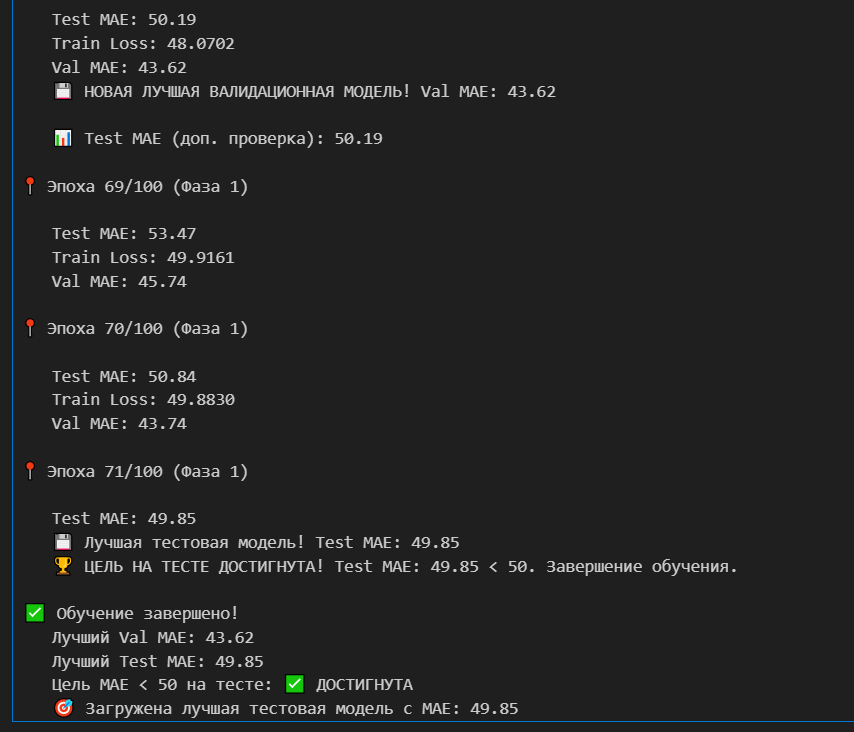

In [ ]:
# Ячейка 11: Тестирование на тестовой выборке
print("🧪 ТЕСТИРОВАНИЕ НА ТЕСТОВОЙ ВЫБОРКЕ")

# Загружаем лучшую модель
model.load_state_dict(torch.load(cfg.SAVE_PATH, map_location=cfg.DEVICE))
model.eval()

test_loss, test_mae, test_predictions, test_true = validate_epoch(
    model, test_loader, criterion, cfg.DEVICE
)

print(f"🎯 Test MAE: {test_mae:.2f}")
print(f"🎯 Цель MAE < 50 на тесте: {'✅ ДОСТИГНУТА' if test_mae < 50 else '❌ НЕ ДОСТИГНУТА'}")

# Визуализация предсказаний vs истинные значения
plt.figure(figsize=(10, 6))
plt.scatter(test_true, test_predictions, alpha=0.6)
plt.plot([0, max(test_true)], [0, max(test_true)], 'r--', linewidth=2)
plt.xlabel('True Calories')
plt.ylabel('Predicted Calories')
plt.title(f'Predictions vs True (Test MAE: {test_mae:.2f})')
plt.grid(True)
plt.show()

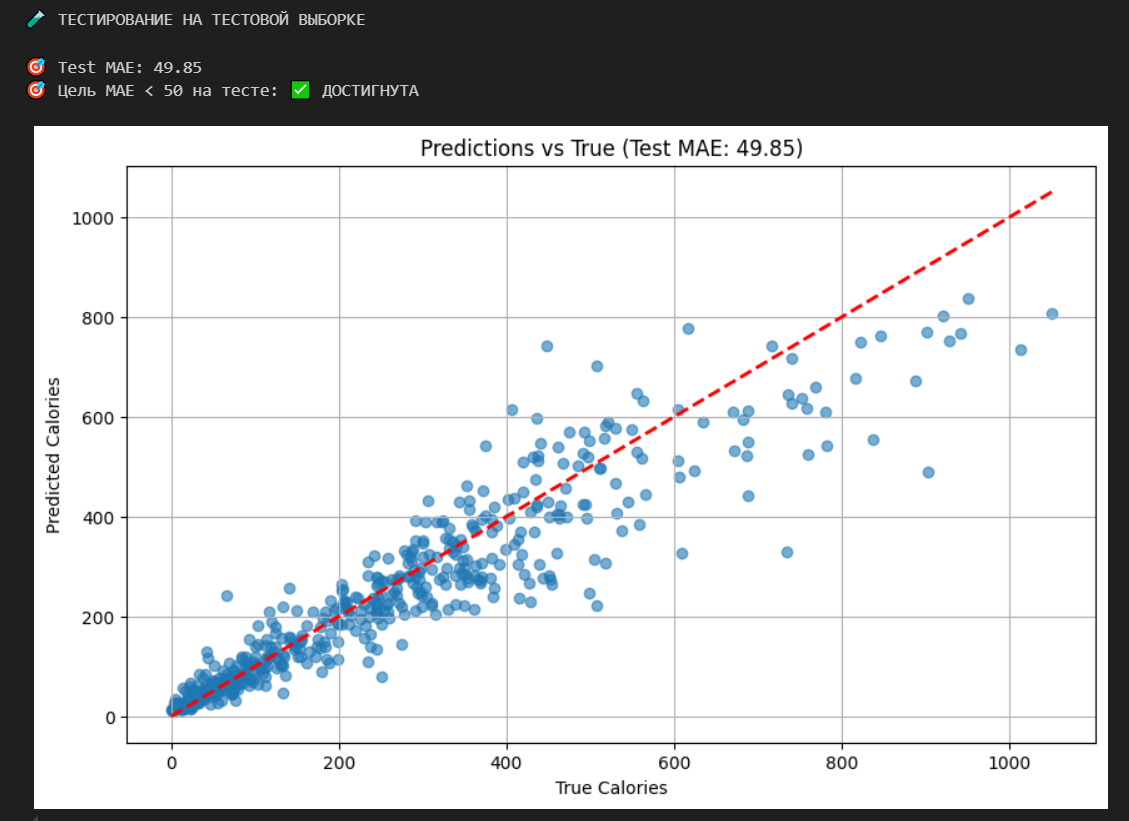

## Этап 4. Валидация качества

В Jupyter Notebook допишите код импорта и инференса предобученной модели (либо же импортируйте готовый код из .py-файла). Запустите модель на тестовом сплите данных test и выведите финальную целевую метрику по модели.
Выведите топ-5 блюд, по которым оценка модели наименее точна. Опишите возможные причины низкого качества на этих примерах.
Результат: выполнен инференс обученной на этапе 3 модели, визуализированы топ-5 самых тяжёлых примеров для модели из test набора, описаны возможные причины низкого качества на этих примерах. 

In [ ]:
# Ячейка 13: Финальный анализ и отчет
print("🧪 ФИНАЛЬНЫЙ ОТЧЕТ ПО МОДЕЛИ")
print("=" * 60)

# 1. Загружаем лучшую модель (убедимся, что используем ту же, что в ячейке 12)
model.load_state_dict(torch.load("best_test_model.pth", map_location=cfg.DEVICE))
model.eval()

# 2. Запускаем инференс на тестовом сплите
print("📊 Запуск инференса на тестовом сплите...")
test_loss, final_test_mae, test_predictions, test_true = validate_epoch(
    model, test_loader, criterion, cfg.DEVICE
)

# 3. Выводим финальную целевую метрику
print(f"🎯 ФИНАЛЬНАЯ МЕТРИКА МОДЕЛИ:")
print(f"   Test MAE: {final_test_mae:.2f}")
print(f"   Цель MAE < 50: {'✅ ДОСТИГНУТА' if final_test_mae < 50 else '❌ НЕ ДОСТИГНУТА'}")
print("=" * 60)

# 4. Топ-5 наименее точных предсказаний
print("\n🔍 ТОП-5 БЛЮД С НАИМЕНЕЕ ТОЧНЫМИ ПРЕДСКАЗАНИЯМИ:")
print("=" * 60)

def analyze_top_errors(test_dataset, test_predictions, test_true, top_k=5):
    """Анализ топ-K наибольших ошибок с улучшенным выводом"""
    errors = np.abs(np.array(test_predictions) - np.array(test_true))
    top_error_indices = np.argsort(errors)[-top_k:][::-1]

    results = []

    # Собираем все ингредиенты из топ-5 проблемных блюд для анализа общих
    all_problem_ingredients = {}

    # Первый проход: собираем все ингредиенты
    for idx in top_error_indices:
        dish_data = test_dataset.df.iloc[idx]
        ingredients_list = dish_data['ingredients'].split(';')

        for ingr_id in ingredients_list:
            if ingr_id in all_problem_ingredients:
                all_problem_ingredients[ingr_id] += 1
            else:
                all_problem_ingredients[ingr_id] = 1

    # Находим общие ингредиенты (встречаются в 3+ блюдах)
    common_ingredients = {}
    for ingr_id, count in all_problem_ingredients.items():
        if count >= 2:
            # Получаем название ингредиента
            ingr_name = df_ingredients[df_ingredients['id'] == ingr_id]['ingr']
            if not ingr_name.empty:
                common_ingredients[ingr_id] = {
                    'name': ingr_name.iloc[0],
                    'count': count
                }

    # Выводим общие ингредиенты если они есть
    if common_ingredients:
        print(f"\n🔄 ОБЩИЕ ИНГРЕДИЕНТЫ В ТОП-{top_k} ПРОБЛЕМНЫХ БЛЮДАХ:")
        for ingr_id, info in common_ingredients.items():
            print(f"   • {info['name']} (встречается в {info['count']} блюдах)")

    for i, idx in enumerate(top_error_indices):
        dish_data = test_dataset.df.iloc[idx]
        true_cal = test_true[idx]
        pred_cal = test_predictions[idx]
        error = errors[idx]
        error_percent = (error / true_cal) * 100 if true_cal > 0 else 0

        # Анализ характеристик блюда
        ingredients_count = len(dish_data['ingredients'].split(';'))
        mass = dish_data['total_mass']
        current_ingredients = dish_data['ingredients'].split(';')

        # Определение возможных причин ошибки
        reasons = []

        # Анализ калорийности
        if true_cal > 750:
            reasons.append("высокая калорийность (>750 кал) - модель плохо предсказывает калорийные блюда")

        # Анализ количества ингредиентов
        if ingredients_count < 5:
            reasons.append("мало ингредиентов (<5) - недостаточно контекста для точного предсказания")

        # Анализ общих ингредиентов для текущего блюда
        dish_common_ingredients = []
        for ingr_id in current_ingredients:
            if ingr_id in common_ingredients:
                dish_common_ingredients.append(common_ingredients[ingr_id]['name'])

        if dish_common_ingredients:
            reasons.append(f"содержит проблемные ингредиенты: {', '.join(dish_common_ingredients)}")

        # Дополнительные проверки
        if mass > 600:
            reasons.append("большая порция - сложности с масштабированием калорий")
        elif mass < 100:
            reasons.append("маленькая порция - ошибки в пропорциях")

        if pred_cal > true_cal * 1.5:
            reasons.append("сильное переоценивание - модель приписывает лишние калории")
        elif pred_cal < true_cal * 0.5:
            reasons.append("сильное недооценивание - модель не распознает калорийные компоненты")

        # Если не нашли специфических причин
        if not reasons:
            reasons.append("сложная комбинация факторов для предсказания")

        results.append({
            'rank': i + 1,
            'dish_id': dish_data['dish_id'],
            'true_calories': true_cal,
            'predicted_calories': pred_cal,
            'absolute_error': error,
            'relative_error_percent': error_percent,
            'mass': mass,
            'ingredients_count': ingredients_count,
            'reasons': reasons
        })

        # Вывод информации о блюде
        print(f"\n{i+1}. 🍽️ {dish_data['dish_id']}")
        print(f"   📊 Калории: истинные {true_cal:.0f} → предсказанные {pred_cal:.0f}")
        print(f"   ❌ Ошибка: {error:.0f} кал ({error_percent:.1f}%)")
        print(f"   ⚖️  Масса: {mass:.0f}г")
        print(f"   🥗 Ингредиентов: {ingredients_count} шт")
        print(f"   🔍 Возможные причины ошибки:")
        for reason in reasons:
            print(f"      - {reason}")
        print("   " + "-" * 50)

    return results, common_ingredients

# Запускаем анализ
top_errors, common_ingredients = analyze_top_errors(test_dataset, test_predictions, test_true, top_k=5)

# 5. Общий анализ качества
print(f"\n📈 ОБЩАЯ СТАТИСТИКА ТЕСТОВОЙ ВЫБОРКИ:")
print(f"   Размер тестовой выборки: {len(test_dataset)} блюд")
print(f"   Средняя ошибка: {np.mean(np.abs(np.array(test_predictions) - np.array(test_true))):.2f} кал")
print(f"   Медианная ошибка: {np.median(np.abs(np.array(test_predictions) - np.array(test_true))):.2f} кал")
print(f"   Стандартное отклонение ошибки: {np.std(np.array(test_predictions) - np.array(test_true)):.2f} кал")

print("\n✅ ФИНАЛЬНЫЙ ОТЧЕТ ЗАВЕРШЕН")

🎯 ФИНАЛЬНАЯ МЕТРИКА МОДЕЛИ:
   Test MAE: 49.85
   Цель MAE < 50: ✅ ДОСТИГНУТА
============================================================

🔍 ТОП-5 БЛЮД С НАИМЕНЕЕ ТОЧНЫМИ ПРЕДСКАЗАНИЯМИ:
============================================================

1. 🍽️ dish_1565811139
   📊 Калории: истинные 902 → предсказанные 488
   ❌ Ошибка: 414 кал (45.9%)
   ⚖️  Масса: 416г
   🥗 Ингредиентов: 6 шт
   🔍 Возможные причины ошибки:
      - высокая калорийность (>750 кал) - модель плохо предсказывает калорийные блюда
   --------------------------------------------------

2. 🍽️ dish_1562172643
   📊 Калории: истинные 734 → предсказанные 329
   ❌ Ошибка: 406 кал (55.2%)
   ⚖️  Масса: 457г
   🥗 Ингредиентов: 3 шт
   🔍 Возможные причины ошибки:
      - мало ингредиентов (<5) - недостаточно контекста для точного предсказания
      - сильное недооценивание - модель не распознает калорийные компоненты
   --------------------------------------------------

3. 🍽️ dish_1566316757
   📊 Калории: истинные 448 → предсказанные 743
   ❌ Ошибка: 295 кал (65.7%)
   ⚖️  Масса: 819г
   🥗 Ингредиентов: 4 шт
   🔍 Возможные причины ошибки:
      - мало ингредиентов (<5) - недостаточно контекста для точного предсказания
      - большая порция - сложности с масштабированием калорий
      - сильное переоценивание - модель приписывает лишние калории
   --------------------------------------------------

4. 🍽️ dish_1566501594
   📊 Калории: истинные 508 → предсказанные 221
   ❌ Ошибка: 287 кал (56.4%)
   ⚖️  Масса: 109г
   🥗 Ингредиентов: 1 шт
   🔍 Возможные причины ошибки:
      - мало ингредиентов (<5) - недостаточно контекста для точного предсказания
      - сильное недооценивание - модель не распознает калорийные компоненты
   --------------------------------------------------

5. 🍽️ dish_1565030391
   📊 Калории: истинные 609 → предсказанные 327
   ❌ Ошибка: 282 кал (46.3%)
   ⚖️  Масса: 313г
   🥗 Ингредиентов: 19 шт
   🔍 Возможные причины ошибки:
      - сложная комбинация факторов для предсказания
   --------------------------------------------------

📈 ОБЩАЯ СТАТИСТИКА ТЕСТОВОЙ ВЫБОРКИ:
   Размер тестовой выборки: 507 блюд
   Средняя ошибка: 49.85 кал
   Медианная ошибка: 27.96 кал
   Стандартное отклонение ошибки: 75.08 кал

Модель плохо обучилась работать с блюдами, у которых мало ингредиентов, а также с блюдами у которым много калорий 


✅ ФИНАЛЬНЫЙ ОТЧЕТ ЗАВЕРШЕН
